In [2]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jeishun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data_path = "dontpatronizeme_pcl.tsv"

cols = ["id", "par_id", "keyword", "country", "text", "label"]

df = pd.read_csv(data_path, sep="\t", names=cols, header=None, skiprows=3)
df.head(10)

,id,par_id,keyword,country,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
5,6,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0
6,7,@@7562079,refugee,za,The European Union is making an historic mista...,0
7,8,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0
8,9,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1
9,10,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0


## 0. Light Pre-processing

In [5]:
# One NA entry in dataset
print(f"Before dropping: {df['text'].isna().sum()}")
df = df.dropna(subset=['text'])
print(f"After dropping: {df['text'].isna().sum()}")

Before dropping: 1
After dropping: 0


## 1. Basic Statistical Profiling

### 1.1 Token Counts

In [6]:
# average, min, and max sentence lengths

df['num_chars'] = df["text"].str.len()
df["num_words"] = df["text"].str.split().apply(len)

df[["num_chars", "num_words"]].describe(percentiles=[.25, .5, .75, 0.9, 0.99])

,num_chars,num_words
count,10468.000000,10468.000000
mean,266.535250,48.427111
std,159.865329,29.088870
min,8.000000,1.000000
25%,168.000000,30.000000
50%,232.000000,42.000000
75%,329.000000,60.000000
90%,454.000000,83.000000
99%,772.000000,141.330000
max,5493.000000,909.000000


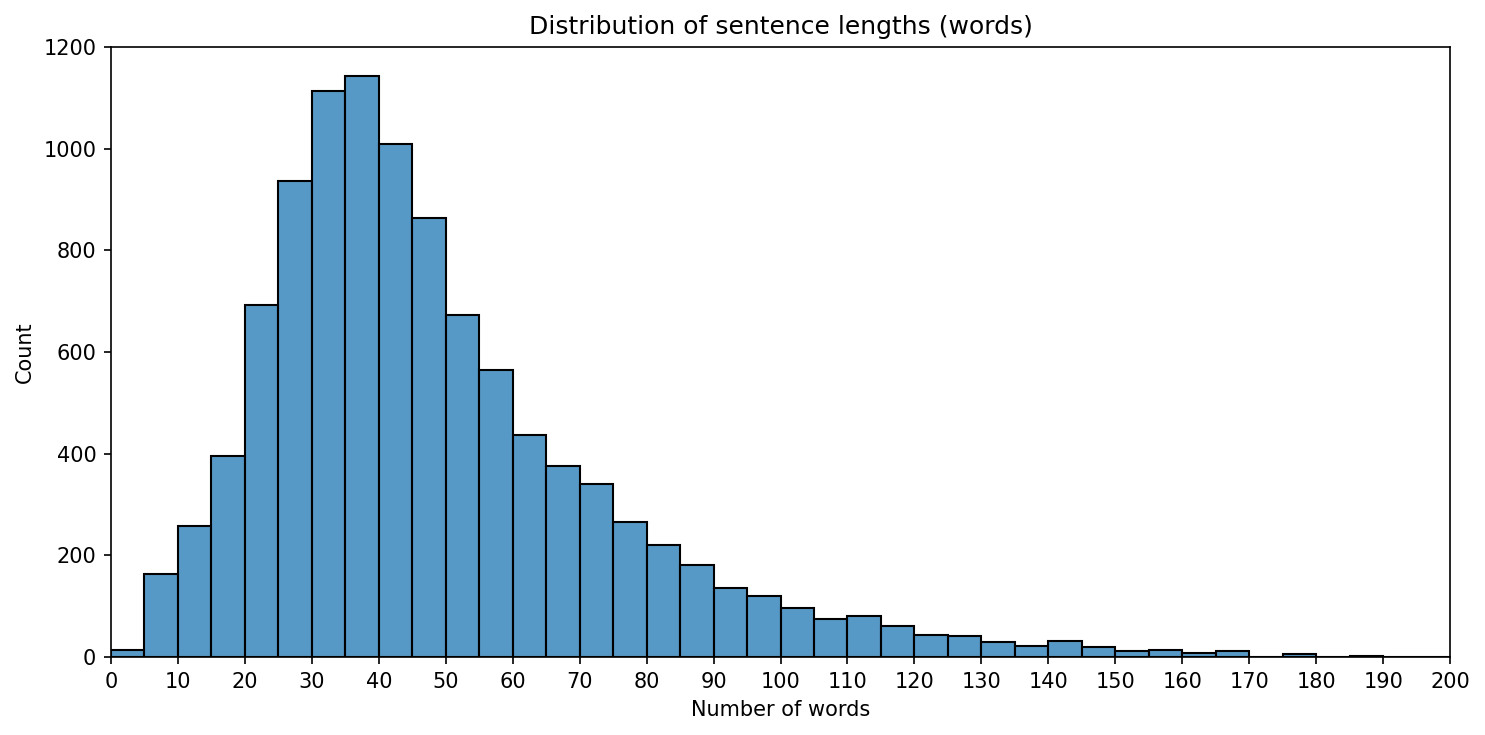

In [7]:
bins = np.arange(0, 201, 5)

plt.figure(figsize=(10, 5), dpi=150)

sns.histplot(
    df["num_words"],
    bins=bins,
    edgecolor="black"
)

plt.xlim(0, 200)

plt.xticks(np.arange(0, 201, 10))

plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Distribution of sentence lengths (words)")
plt.tight_layout()
plt.show()

In [8]:
outliers = (df["num_words"] > 128).sum()
outliers_percentage = (df["num_words"] > 128).sum() / len(df)
print(outliers)
print(outliers_percentage)

178
0.01700420328620558


### 1.2 Vocabulary Size

In [9]:
all_words = " ".join(df["text"]).lower().split()
vocab = set(all_words)

print(f"Vocabulary size: {len(vocab)}")
print(f"Total words: {len(all_words)}")

Vocabulary size: 33234
Total words: 506935


In [10]:
# Lexical diversity (unique words / total words)
len(vocab) / len(all_words)

0.06555870081963171

### 1.3 Label Distribution

In [9]:
label_counts = df["label"].value_counts()
label_proportions = df["label"].value_counts(normalize=True).mul(100)

label_stats = pd.concat(
    [
        label_counts,
        label_proportions
    ],
    axis=1,
    keys=["count", "proportion (%)"]
)

label_stats


,count,proportion (%)
label,,
0,8528,81.467329
1,947,9.046618
3,458,4.375239
4,391,3.735193
2,144,1.375621


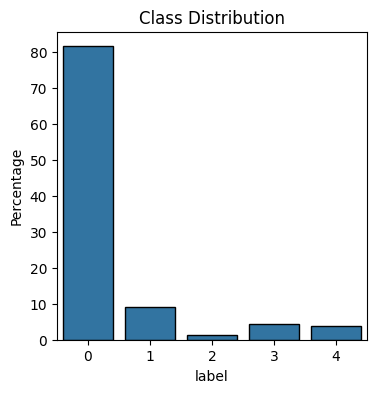

In [10]:
plt.figure(figsize=(4,4))

sns.barplot(
    x=label_proportions.index, 
    y=label_proportions.values, 
    edgecolor="black"
)

plt.ylabel("Percentage")
plt.title("Class Distribution")
plt.show()

## 2. Lexical Analysis

In [13]:
stop_words = set(stopwords.words("english"))

In [14]:
# Remove punctuation and change to lower case

import unicodedata

def tokenize(text):
    text = text.lower()
    text = "".join(
        ch for ch in text
        if not unicodedata.category(ch).startswith("P")
    )
    return text.split()

### 2.1 N-gram Analysis

#### Uncleaned

In [15]:
all_words = " ".join(df["text"]).lower().split()
filtered_words = [w for w in all_words if w not in stop_words]
Counter(filtered_words).most_common(20)


[(',', 21705),
 ('.', 18253),
 ('"', 6036),
 ("'s", 3106),
 ('said', 2159),
 ('people', 1840),
 ('women', 1704),
 ('need', 1344),
 ('families', 1339),
 ('immigrants', 1292),
 ("'", 1260),
 ('vulnerable', 1202),
 (')', 1182),
 ('poor', 1173),
 ('(', 1170),
 ('disabled', 1123),
 ('children', 1038),
 ('homeless', 1030),
 ('--', 1008),
 ('also', 984)]

In [16]:
bigrams = list(ngrams(filtered_words, 2))
Counter(bigrams).most_common(20)


[(('.', '"'), 2224),
 ((',', '"'), 1210),
 (('poor', 'families'), 909),
 (('"', 'said'), 445),
 (('said', '.'), 445),
 ((',', 'said'), 342),
 (('illegal', 'immigrants'), 305),
 ((',', 'including'), 211),
 ((')', ','), 209),
 (('families', '.'), 207),
 (('.', '<h>'), 200),
 (('.', 'said'), 197),
 (('women', "'s"), 195),
 (('need', '.'), 195),
 (('.', ','), 192),
 (('.', "'s"), 191),
 (('women', ','), 189),
 ((':', '"'), 188),
 (('immigrants', ','), 186),
 (('however', ','), 183)]

#### Cleaned

In [17]:
all_words_clean = []
for text in df["text"]:
    all_words_clean.extend(tokenize(text))

In [18]:
filtered_words_clean = [w for w in all_words_clean if w not in stop_words]
Counter(filtered_words_clean).most_common(20)


[('said', 2160),
 ('people', 1840),
 ('women', 1705),
 ('need', 1344),
 ('families', 1341),
 ('immigrants', 1293),
 ('vulnerable', 1202),
 ('poor', 1173),
 ('disabled', 1124),
 ('children', 1038),
 ('homeless', 1031),
 ('also', 984),
 ('refugees', 965),
 ('one', 906),
 ('government', 835),
 ('would', 809),
 ('new', 805),
 ('many', 788),
 ('country', 746),
 ('us', 738)]

In [19]:
bigrams = list(ngrams(filtered_words_clean, 2))
Counter(bigrams).most_common(20)


[(('poor', 'families'), 911),
 (('illegal', 'immigrants'), 307),
 (('per', 'cent'), 165),
 (('united', 'states'), 161),
 (('homeless', 'people'), 136),
 (('last', 'year'), 128),
 (('disabled', 'people'), 119),
 (('people', 'need'), 112),
 (('sri', 'lanka'), 108),
 (('new', 'york'), 104),
 (('men', 'women'), 102),
 (('hong', 'kong'), 102),
 (('donald', 'trump'), 98),
 (('human', 'rights'), 90),
 (('ca', 'nt'), 87),
 (('women', 'children'), 85),
 (('children', 'poor'), 85),
 (('migrant', 'workers'), 72),
 (('new', 'zealand'), 72),
 (('million', 'people'), 71)]

### 2.2 Stop Word Density

In [20]:
stop_words = set(stopwords.words("english"))

df["stopword_ratio"] = df["text"].apply(
    lambda x: sum(1 for w in tokenize(x) if w in stop_words) / len(tokenize(x))
)

df["stopword_ratio"].describe()

count    10468.000000
mean         0.421292
std          0.088742
min          0.000000
25%          0.368421
50%          0.423077
75%          0.478261
max          0.750000
Name: stopword_ratio, dtype: float64

## Something here

In [21]:
pcl_text = df[df["label"] == 1]["text"]
non_pcl_text = df[df["label"] == 0]["text"]

vectorizer = CountVectorizer(stop_words="english", max_features=1000)

X_pcl = vectorizer.fit_transform(pcl_text)
X_non = vectorizer.transform(non_pcl_text)

pcl_freq = np.asarray(X_pcl.sum(axis=0)).flatten()
non_freq = np.asarray(X_non.sum(axis=0)).flatten()

words = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({
    "word": words,
    "pcl": pcl_freq,
    "non_pcl": non_freq
})

freq_df["diff"] = freq_df["pcl"] - freq_df["non_pcl"]
freq_df.sort_values("diff", ascending=False).head(15)


,word,pcl,non_pcl,diff
395,heartbreaking,6,2,4
455,inmates,11,7,4
295,exile,6,3,3
890,talented,5,2,3
885,surplus,5,3,2
547,luke,5,3,2
222,decent,6,4,2
831,sleeping,11,10,1
795,seed,5,4,1
256,dreams,6,6,0


## 4. Identifying Noise and Artifacts

### 4.1 Duplicates

In [22]:
df.duplicated(subset="text").sum()


np.int64(0)

### 4.2 Special Characters

In [23]:
length = df[df["text"].str.contains(r"&amp;|\n|\t", regex=True)].shape[0]
print(length)

61


### 4.3 Outliers

In [24]:
df.sort_values("num_words", ascending=False).head(5)[["text", "num_words"]]

,text,num_words
7418,Dr Mayengbam Lalit Singh Recently honourable P...,909
6832,Most are from desperately poor Horn of Africa ...,512
5977,"Mahinda Wijesinghe , the Inspector General of ...",419
8191,ANNUAL State of Education Report ( ASER ) laun...,390
9810,Two goals in the third quarter put the Ballysh...,272
